In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
from scipy import ndimage
import matplotlib.pyplot as plt
import statistics
import pandas as pd
from datetime import datetime
from scipy.stats import poisson
import plotly.express as px
import numpy as np

Gathers enrichment data.

In [2]:
econ = pd.read_csv("../../../../data/econ_data_with_overlays.csv", low_memory=False)
housing = pd.read_csv("../../../../data/housing_data_with_overlays.csv", low_memory=False)
social = pd.read_csv("../../../../data/social_data_with_overlays.csv", low_memory=False)

econ = econ.rename(columns = econ.iloc[0]).drop([0])
housing = housing.rename(columns = housing.iloc[0]).drop([0])
social = social.rename(columns = social.iloc[0]).drop([0])

Merges covid data from all files and makes the dates into a column that will later be used to group the covid cases and deaths.

In [3]:
cases = pd.read_csv("../../../../data/new_covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../../../../data/new_covid_deaths_usafacts.csv")
pop = pd.read_csv("../../../../data/new_covid_county_population_usafacts.csv")

cases = cases[cases['County Name'] != 'Statewide Unallocated']
deaths = deaths[deaths['County Name'] != 'Statewide Unallocated']

pop = pop[pop['County Name'] != 'Statewide Unallocated']
pop = pop.drop(columns = ['County Name'])

Removes date column to change it into a date_Time type. Values are then sorted by date and county FIP.

In [4]:
deathsandpop = pd.merge(deaths, pop, on = ['countyFIPS', 'State'])
deathsandpop2 = pd.melt(deathsandpop, id_vars=['countyFIPS','State','County Name','StateFIPS','population'],var_name='Date', value_name='Deaths')
cases_long = pd.melt(cases, id_vars=['countyFIPS','State','County Name','StateFIPS'], var_name='Date', value_name='Cases')
alldata = pd.merge(deathsandpop2,cases_long, on=['countyFIPS','State','County Name','StateFIPS', 'Date'])

Converting Date column to datetime.

In [5]:
separateddatecol = pd.DataFrame(pd.to_datetime(alldata['Date']))
alldatanodate = pd.DataFrame(alldata.drop(columns = ['Date']))
updated = pd.concat([separateddatecol.reset_index(drop=True),alldatanodate.reset_index(drop=True)], axis = 1). fillna(0)
updated = updated.sort_values(by=['countyFIPS', 'Date'])

Calculates new cases and deaths per day by finding the difference between the number of cases on one date and the cases of that date's predecessor. They are put into their own columns in the "updated" table.

In [6]:
updated['New_Cases_Per_Day'] = updated.groupby('countyFIPS').Cases.diff()
updated['New_Deaths_Per_Day'] = updated.groupby('countyFIPS').Deaths.diff()
updated['New_Cases_Per_Day'] = np.where(updated['New_Cases_Per_Day'] < 0, 0, updated['New_Cases_Per_Day'])
updated['New_Deaths_Per_Day'] = np.where(updated['New_Deaths_Per_Day'] < 0, 0, updated['New_Deaths_Per_Day'])

Finds only data for the state of California.

In [7]:
caData = updated.loc[updated['State'] == 'CA'].reset_index(drop=True)
caData['Normalized_Cases_Per_Day'] = (caData['New_Cases_Per_Day']/caData['population']) * 100000
caData['Normalized_Deaths_Per_Day'] = (caData['New_Deaths_Per_Day']/caData['population']) * 100000
caData['Normalized_Deaths_Per_Day'] = caData['Normalized_Deaths_Per_Day'].round(decimals = 2).fillna(0)
caData['Normalized_Cases_Per_Day'] = caData['Normalized_Cases_Per_Day'].round(decimals = 2).fillna(0)

### pmf functions of California's new Cases and deaths per day.

variance:
380744.904283428
skew:
18.083543587114608
kurtosis:
455.2062961459124
center:
(17778.47006482332,)


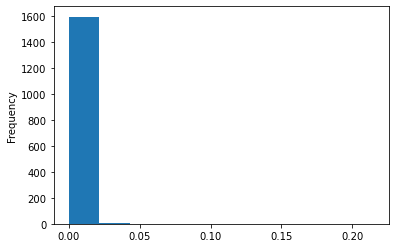

In [8]:
from scipy.stats import kurtosis, skew

pmf =caData['New_Cases_Per_Day'].value_counts().sort_index() / len(caData['New_Cases_Per_Day'])
pmf.plot(kind='hist')

variance = statistics.pvariance(caData['New_Cases_Per_Day'].fillna(0))
skew = skew(caData['New_Cases_Per_Day'].fillna(0))
kurtosis = kurtosis(caData['New_Cases_Per_Day'].fillna(0))
center = ndimage.measurements.center_of_mass(caData['New_Cases_Per_Day'].fillna(0))

print('variance:')
print(variance)
print('skew:')
print(skew)
print('kurtosis:')
print(kurtosis)
print('center:')
print(center)

variance:
109.96823483552605
skew:
17.099099716616035
kurtosis:
383.1593713262149
center:
(17147.126013803187,)


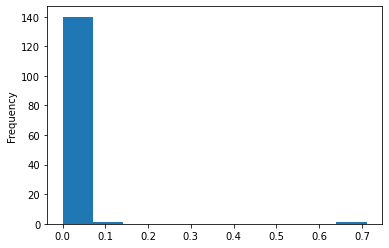

In [9]:
from scipy.stats import kurtosis, skew

pmf =caData['New_Deaths_Per_Day'].value_counts().sort_index() / len(caData['New_Deaths_Per_Day'])
pmf.plot(kind='hist')

variance = statistics.pvariance(caData['New_Deaths_Per_Day'].fillna(0))
skew = skew(caData['New_Deaths_Per_Day'].fillna(0))
kurtosis = kurtosis(caData['New_Deaths_Per_Day'].fillna(0))
center = ndimage.measurements.center_of_mass(caData['New_Deaths_Per_Day'].fillna(0))

print('variance:')
print(variance)
print('skew:')
print(skew)
print('kurtosis:')
print(kurtosis)
print('center:')
print(center)

### Comparing distributions of 5 other states

Gathering state data for the states that are to be compared to california.

In [10]:
haData = updated.loc[updated['State'] == 'HI'].reset_index(drop=True)
waData = updated.loc[updated['State'] == 'WA'].reset_index(drop=True)
flData = updated.loc[updated['State'] == 'FL'].reset_index(drop=True)
laData = updated.loc[updated['State'] == 'LA'].reset_index(drop=True)
paData = updated.loc[updated['State'] == 'PA'].reset_index(drop=True)

Comparing states distributions for deaths.

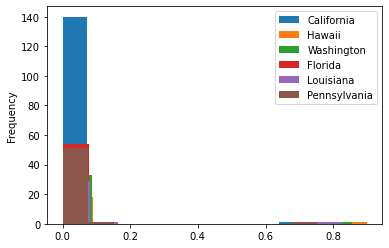

In [11]:
pmf =caData['New_Deaths_Per_Day'].value_counts().sort_index() / len(caData['New_Deaths_Per_Day'])
pmf.plot(label = 'California',kind='hist')
pmf =haData['New_Deaths_Per_Day'].value_counts().sort_index() / len(haData['New_Deaths_Per_Day'])
pmf.plot(label = 'Hawaii',kind='hist')
pmf =waData['New_Deaths_Per_Day'].value_counts().sort_index() / len(waData['New_Deaths_Per_Day'])
pmf.plot(label = 'Washington',kind='hist')
pmf =flData['New_Deaths_Per_Day'].value_counts().sort_index() / len(flData['New_Deaths_Per_Day'])
pmf.plot(label = 'Florida',kind='hist')
pmf =laData['New_Deaths_Per_Day'].value_counts().sort_index() / len(laData['New_Deaths_Per_Day'])
pmf.plot(label = 'Louisiana',kind='hist')
pmf =paData['New_Deaths_Per_Day'].value_counts().sort_index() / len(paData['New_Deaths_Per_Day'])
pmf.plot(label = 'Pennsylvania',kind='hist')
plt.legend()

Comparing states distributions for deaths.

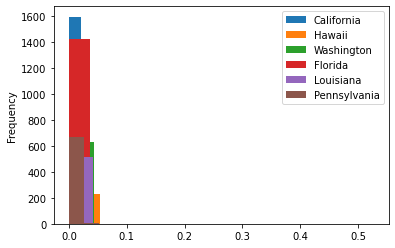

In [12]:
pmf =caData['New_Cases_Per_Day'].value_counts().sort_index() / len(caData['New_Cases_Per_Day'])
pmf.plot(label = 'California',kind='hist')
pmf =haData['New_Cases_Per_Day'].value_counts().sort_index() / len(haData['New_Cases_Per_Day'])
pmf.plot(label = 'Hawaii',kind='hist')
pmf =waData['New_Cases_Per_Day'].value_counts().sort_index() / len(waData['New_Cases_Per_Day'])
pmf.plot(label = 'Washington',kind='hist')
pmf =flData['New_Cases_Per_Day'].value_counts().sort_index() / len(flData['New_Cases_Per_Day'])
pmf.plot(label = 'Florida',kind='hist')
pmf =laData['New_Cases_Per_Day'].value_counts().sort_index() / len(laData['New_Cases_Per_Day'])
pmf.plot(label = 'Louisiana',kind='hist')
pmf =paData['New_Cases_Per_Day'].value_counts().sort_index() / len(paData['New_Cases_Per_Day'])
pmf.plot(label = 'Pennsylvania',kind='hist')
plt.legend()

Comparison of states stats.

In [13]:
from scipy.stats import kurtosis, skew
statsdf = pd.DataFrame(columns =['State','Center','Variance','Skewness','Kurtosis'])
CAstats = {'State': 'CA','Center':ndimage.measurements.center_of_mass(caData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(caData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(caData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(caData['New_Deaths_Per_Day'].fillna(0))}
HAstats = {'State': 'HA','Center':ndimage.measurements.center_of_mass(haData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(haData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(haData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(haData['New_Deaths_Per_Day'].fillna(0))}
WAstats = {'State': 'WA','Center':ndimage.measurements.center_of_mass(waData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(waData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(waData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(waData['New_Deaths_Per_Day'].fillna(0))}
FLstats = {'State': 'FL','Center':ndimage.measurements.center_of_mass(flData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(flData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(flData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(flData['New_Deaths_Per_Day'].fillna(0))}
LAstats = {'State': 'LA','Center':ndimage.measurements.center_of_mass(laData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(laData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(laData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(laData['New_Deaths_Per_Day'].fillna(0))}
PAstats = {'State': 'PA','Center':ndimage.measurements.center_of_mass(paData['New_Deaths_Per_Day'].fillna(0)),'Variance':statistics.pvariance(paData['New_Deaths_Per_Day'].fillna(0)),'Skewness':skew(paData['New_Deaths_Per_Day'].fillna(0)),'Kurtosis':kurtosis(paData['New_Deaths_Per_Day'].fillna(0))}

statsdf=statsdf.append(CAstats,ignore_index=True)
statsdf=statsdf.append(HAstats,ignore_index=True)
statsdf=statsdf.append(WAstats,ignore_index=True)
statsdf=statsdf.append(FLstats,ignore_index=True)
statsdf=statsdf.append(LAstats,ignore_index=True)
statsdf=statsdf.append(PAstats,ignore_index=True)
statsdf

,State,Center,Variance,Skewness,Kurtosis
0,CA,"(17147.126013803187,)",109.968235,17.099100,383.159371
1,HA,"(1224.2584650112867,)",2.137333,16.807964,479.156721
2,WA,"(14070.833944648217,)",2.424754,16.101785,517.218957
3,FL,"(22895.085993049986,)",9.507855,9.340211,177.100506
4,LA,"(19249.079271227227,)",1.506651,9.827234,178.349365
5,PA,"(20643.153383313493,)",7.524825,22.964168,1137.731162


Convert date column to datetime datatype.

### Model poisson distribution for deaths and cases of California. Compare to 5 other states.

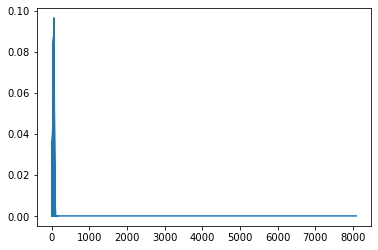

In [14]:
x = caData['Normalized_Cases_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= caData['Normalized_Cases_Per_Day'].mean(), loc = 40)
plt.plot(x, y)

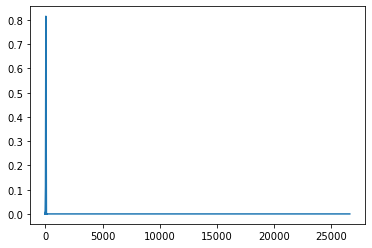

In [15]:
x = caData['Normalized_Deaths_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= caData['Normalized_Deaths_Per_Day'].mean(), loc=40)
plt.plot(x, y)

### Model Poisson distributions for some NC counties

In [16]:
ncdata = updated.loc[updated['State'] == 'NC'].reset_index(drop=True)
ncdata['Normalized_Cases_Per_Day'] = (ncdata['New_Cases_Per_Day']/ncdata['population']) * 100000
ncdata['Normalized_Deaths_Per_Day'] = (ncdata['New_Deaths_Per_Day']/ncdata['population']) * 100000
ncdata['Normalized_Deaths_Per_Day'] = ncdata['Normalized_Deaths_Per_Day'].round(decimals = 2).fillna(0)
ncdata['Normalized_Cases_Per_Day'] = ncdata['Normalized_Cases_Per_Day'].round(decimals = 2).fillna(0)

Alamance = ncdata.loc[ncdata['County Name'].str.contains(pat ='Alamance County')]
Wilson = ncdata.loc[ncdata['County Name'].str.contains(pat ='Wilson County')]
Wilkes =ncdata.loc[ncdata['County Name'].str.contains(pat ='Wilkes County')]

## Poisson distributions for each county. 
#### Alamance Deaths and cases in that order are first.

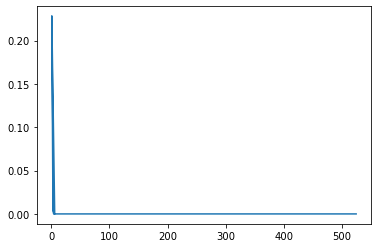

In [17]:
x = Alamance['Normalized_Deaths_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Alamance['Normalized_Deaths_Per_Day'].mean())
plt.plot(x, y)

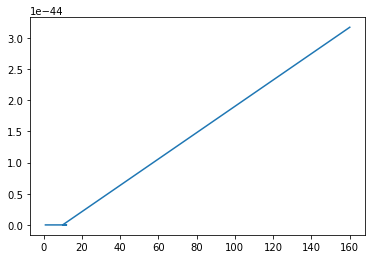

In [18]:
x = Alamance['Normalized_Cases_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Alamance['Normalized_Cases_Per_Day'].mean(), loc = 40)
plt.plot(x,y)

#### Wilson County deaths and cases.

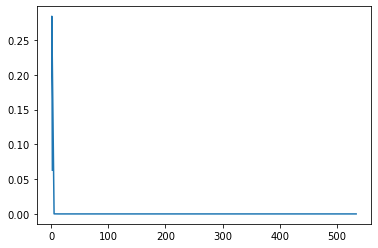

In [19]:
x = Wilson['Normalized_Deaths_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Wilson['Normalized_Deaths_Per_Day'].mean())
plt.plot(x, y)

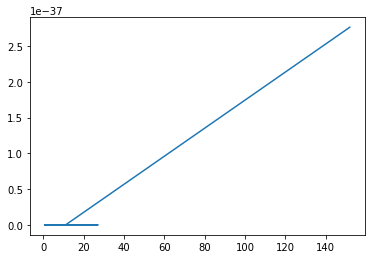

In [20]:
x = Wilson['Normalized_Cases_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Wilson['Normalized_Cases_Per_Day'].mean(),loc = 40)
plt.plot(x, y)

#### Wilkes County Deaths and Cases.

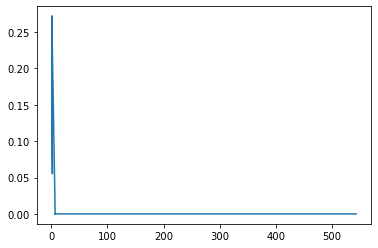

In [21]:
x = Wilkes['Normalized_Deaths_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Wilkes['Normalized_Deaths_Per_Day'].mean())
plt.plot(x, y)

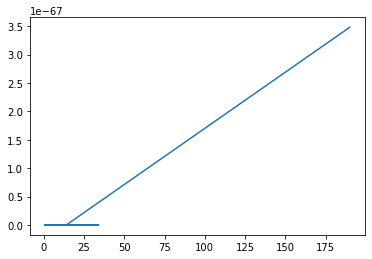

In [22]:
x = Wilkes['Normalized_Cases_Per_Day'].value_counts().sort_index()
y = poisson.pmf(x, mu= Wilkes['Normalized_Cases_Per_Day'].mean(), loc = 40)
plt.plot(x, y)

## Corelation between Enrichment data variables and Covid-19.

In [23]:
updated['Normalized_Cases_Per_Day'] = (updated['New_Cases_Per_Day']/updated['population']) * 100000
updated['Normalized_Deaths_Per_Day'] = (updated['New_Deaths_Per_Day']/updated['population']) * 100000

In [24]:
stateNcounty = econ['Geographic Area Name'].apply(lambda x: pd.Series(str(x).split(",")))
stateNcounty[0] = stateNcounty[0].apply(lambda x: pd.Series(str(x).replace("[","")))
stateNcounty[1] = stateNcounty[1].apply(lambda x: pd.Series(str(x).replace("]","")))

In [31]:
econ.insert(1,"State",stateNcounty[1])
econ.insert(1,"County Name",stateNcounty[0])
social.insert(1,"State",stateNcounty[1])
social.insert(1,"County Name",stateNcounty[0])
housing.insert(1,"State",stateNcounty[1])
housing.insert(1,"County Name",stateNcounty[0])
caData = caData.drop(columns=['countyFIPS','StateFIPS'])

In [32]:
econCA = econ.loc[econ['State'].str.contains(pat ='California')].reset_index(drop=True)
socialCA = social.loc[social['State'].str.contains(pat ='California')].reset_index(drop=True)
housingCA = housing.loc[housing['State'].str.contains(pat ='California')].reset_index(drop=True)
caData2 = caData.groupby(['County Name'])['Deaths','Cases','New_Cases_Per_Day','New_Deaths_Per_Day','Normalized_Cases_Per_Day','Normalized_Deaths_Per_Day'].mean()
caeconCovid = pd.merge(caData2, econCA, on=caData2.index)
cahousingCovid =pd.merge(caData2, housingCA, on=caData2.index)
casocialCovid = pd.merge(caData2, socialCA, on=caData2.index)

### Econ and Covid-19 data

#### Employment status of 16 year olds and older in the labor force correlated with cases and deaths

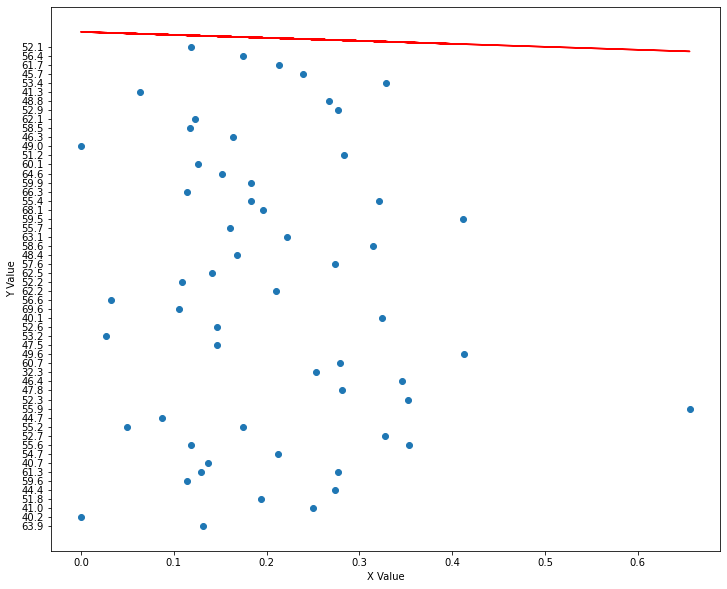

In [50]:
X = caeconCovid['Normalized_Deaths_Per_Day']
Y = caeconCovid['Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric( Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

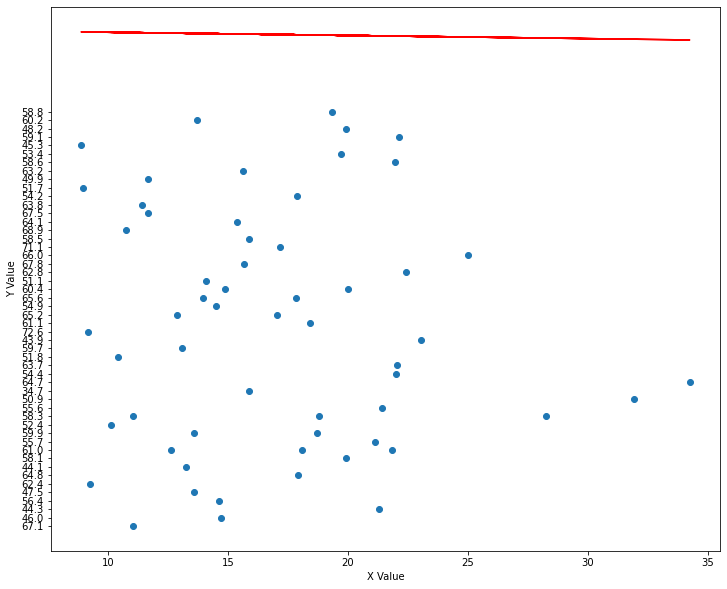

In [34]:
caeconCovid[caeconCovid.columns].apply(pd.to_numeric, errors='coerce')

X = caeconCovid['Normalized_Cases_Per_Day']
Y = caeconCovid['Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

#### Employment status of 16 year olds and older not in the labor force correlated with cases and deaths

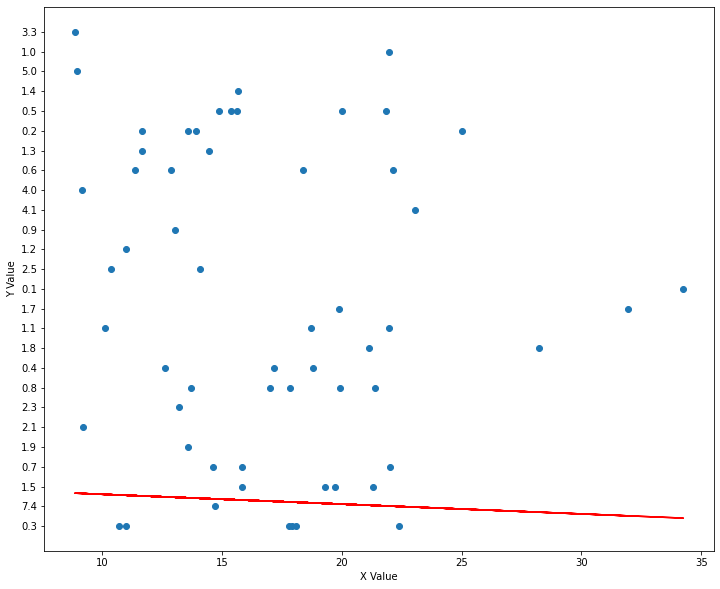

In [51]:
caeconCovid[caeconCovid.columns].apply(pd.to_numeric, errors='coerce')

X = caeconCovid['Normalized_Cases_Per_Day']
Y = caeconCovid['Percent Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

### Housing and Covid-19 Data

### Covid data with Occupied housing data

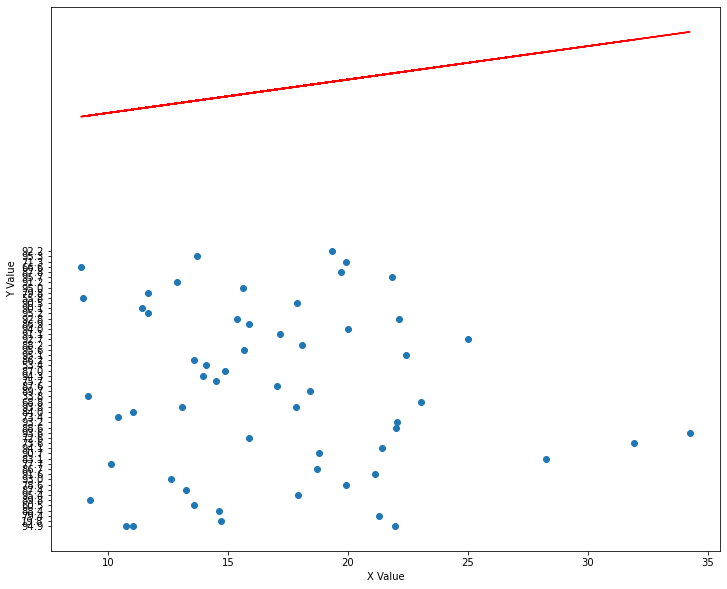

In [52]:
X = cahousingCovid['Normalized_Cases_Per_Day']
Y = cahousingCovid['Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

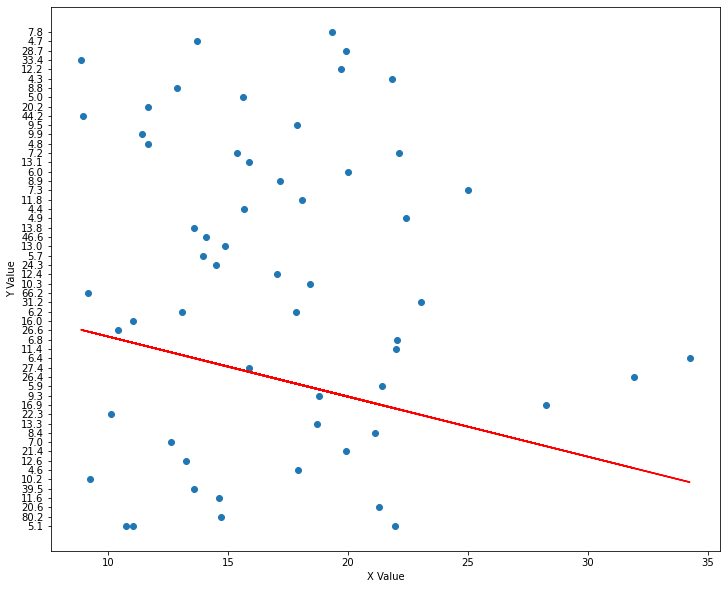

In [53]:
X = cahousingCovid['Normalized_Cases_Per_Day']
Y = cahousingCovid['Percent!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

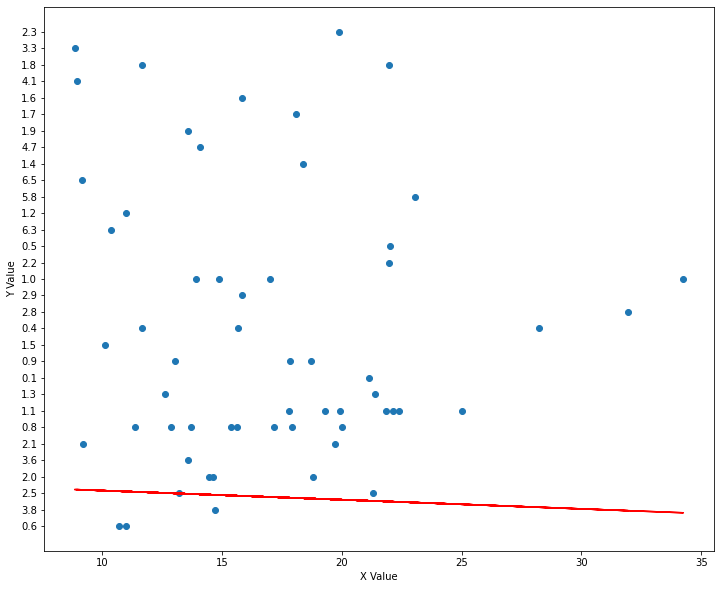

In [54]:
X = cahousingCovid['Normalized_Cases_Per_Day']
Y = cahousingCovid['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

### Social and Covid-19 Data

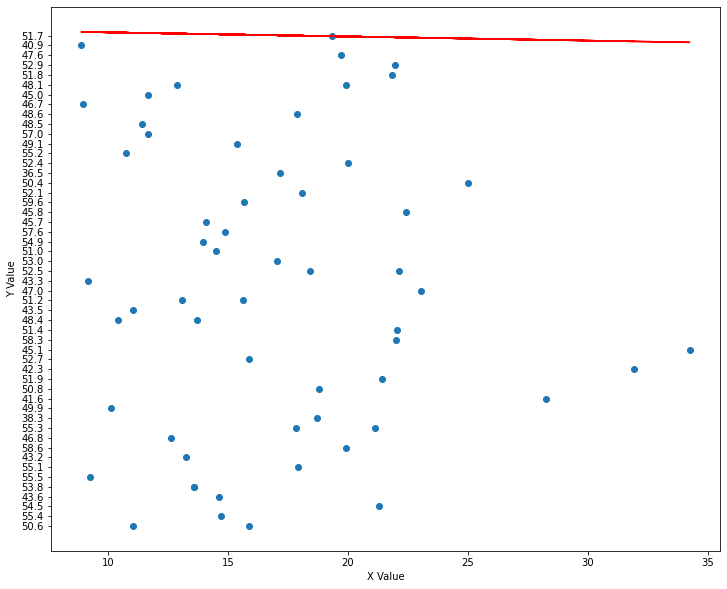

In [56]:
X = casocialCovid['Normalized_Cases_Per_Day']
Y = casocialCovid['Percent!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple family']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

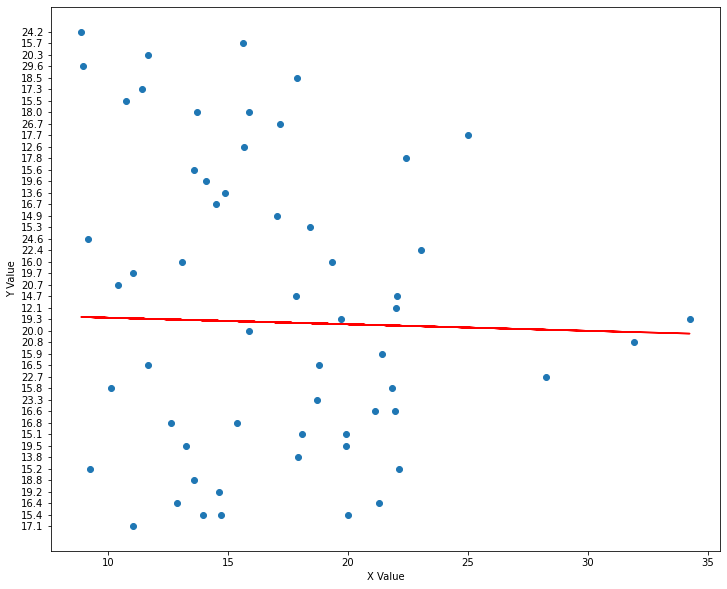

In [57]:
X = casocialCovid['Normalized_Cases_Per_Day']
Y = casocialCovid['Percent!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

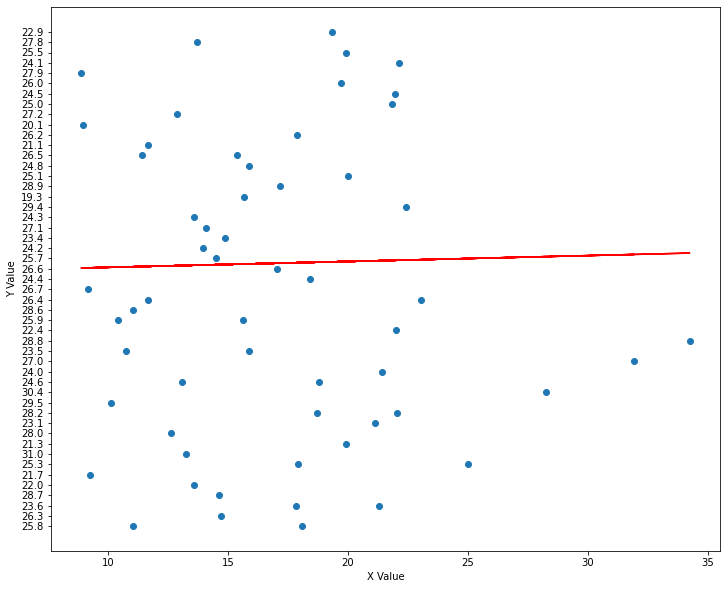

In [58]:
X = casocialCovid['Normalized_Cases_Per_Day']
Y = casocialCovid['Percent!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present']
np.corrcoef(X, Y.astype(float))[0, 1]

m, b = np.polyfit(pd.to_numeric(X),pd.to_numeric(Y), 1)

plt.figure(figsize=(12,10))
plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.plot(X, m*X + b, 'r-')
plt.show("png")

# 3 Enrichment Variable Hypotheses

The correlation with the US economy data and the Covid-19 data is very scattered and is not correlated at all. Therefore my hypothesis is that the employment rate does not lead to a higher or lower Covid case or death rate.

The correlation with the US Housing data and the Covid-19 data, like the previous data, is very scattered and does not seem to be correlated at all. Therefore, my hypothesis is that weather or not there are people housed does not lead to higher or lower cases and deaths due to Covid-19.

The correlation with the US Social data and the Covid-19 data does not seem to be correlated in any way like all the data before it. Therefore my hypothesis is that no societal variabes like living with or without a spouse leads to higher or lower Covid-19 cases or deaths.